# **Modelo de Machine Learning**
---


- #### **Resumo**

A retenção de clientes é um desafio crítico nas empresas, pois a perda de consumidores (churn) impacta diretamente no crescimento e na receita. A aquisição de novos clientes é, geralmente, mais custosa do que a fidelização dos atuais.Nesse contexto, o machine learning surge como uma solução eficaz, permitindo prever churn através da análise de comportamentos e padrões dos clientes. Modelos preditivos identificam fatores de risco e clientes com maior propensão a deixar a empresa, possibilitando intervenções proativas e estratégicas, como personalização de serviços e melhorias no atendimento, que potencializam a fidelidade do cliente e reduzem a taxa de churn. 

A leitura dos dados se realiza utilizando a biblioteca ``pandas``, destacada por sua eficiência na manipulação de dados.

Com base na análise exploratória de dados, foi categorizado os tipos de serviços em uma nova coluna ``Service`` com os valores: "Just Phone", "Just Internet" e "Both".

Também foi criado a coluna ``InternetServicesSum`` para sumarizar os serviços de internet dos clientes, usando serviços como ``OnlineSecurity``, ``OnlineBackup``, entre outros, mapeados em valores binários, aumentando a capacidade preditiva do modelo.

Utilizando ``LabelEncoder``, houve a transformação de colunas categóricas em numéricas. Colunas como ``Partner`` e ``Churn`` foram convertidas em valores binários. Outros serviços foram mapeados manualmente, assegurando uma representação consistente e que melhora a entrada de dados nos modelos preditivos.

Empregando o método one-hot encoding, foram convertidas colunas categóricas como ``gender``, ``InternetService``, e ``PaymentMethod`` em múltiplas colunas binárias, capturando melhor a diversidade dos dados.

Foi optado por categorizar colunas numéricas ao invés de normatizá-las, após testes que apontaram para melhores resultados de modelo. Essa abordagem permite uma segmentação mais clara e eficiente dos dados em grupos e padrões específicos.

Como o conjunto de dados consiste em dados desbalanceados, foi selecionado algorítmos mais eficientes para esse cenário, sendo eles: K-Nearest NeighBors (KNN), Random Forest, Support Vector Machine (SVM), Redes Neurais, Naive Bayes, XGBoost.

Para cada um dos algorítmos, foi realizado N treinamentos testando diferentes hiperparâmetros utilizando o ``GridSearchCV`` (por questão de simplificar a apresentação, não foi add à este notebook).

Analisando as metrícas, chegou à conclusão que o ``Neural Networks`` é o melhor modelo para a previsão de churn. Sua aplicação é atribuída ao cálculo de probabilidade do resultado da previsão, conforme exemplificado.



---

- #### **Leitura do conjunto de dados**

Para a leitura do conjunto de dados (*dataset*), é utilizado a biblioteca ``pandas`` por ser a mais comum e eficiente na manipulação de dados. Não é o caso do presente projeto, mas fica registrado a possibilidade de utilização do framework ``rapids`` desenvolvido pela NVIDIA, que contém bibliotecas como ``cudf`` e ``cuml`` que equivalem ao ``pandas`` e ``scikit-learn``, respectivamente, para utilização do GPU no processamento dos dados, o que consequentemente fornece um ganho de performance computacional e viabiliza tecnicamente a implementação do modelo de machine learning.

In [1]:
import pandas as pd

df = pd.read_csv('dataset/telco_customer_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


- #### **Categorização e soma**

Conforme realizado na análise exploratória de dados, este código está criando uma nova coluna `Service` no dataframe `df` para categorizar os tipos de serviços que os clientes possuem.
- Se o cliente possui apenas serviço de telefone, a coluna `Service` será preenchida com "Just Phone".
- Se o cliente possui apenas serviço de internet, a coluna `Service` será preenchida com "Just Internet".
- Se o cliente possui ambos os serviços, a coluna `Service` será preenchida com "Both".

Além disso, o código está criando uma nova coluna `InternetServicesSum` que soma o número de serviços de internet que o cliente possui. As colunas consideradas para esta soma são: `OnlineSecurit`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` e `StreamingMovies`. Cada serviço é mapeado para 1 se for "Yes" e 0 se for "No" ou "No internet service".

In [2]:
df['Service'] = None
df.loc[(df['PhoneService'] != 'No') & (df['InternetService'] == 'No'), 'Service'] = "Just Phone"
df.loc[(df['PhoneService'] == 'No') & (df['InternetService'] != 'No'), 'Service'] = "Just Internet"
df.loc[(df['PhoneService'] != 'No') & (df['InternetService'] != 'No'), 'Service'] = "Both"
df['InternetServicesSum'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda x: x.map({'Yes': 1, 'No': 0, 'No internet service':0})).sum(axis=1)

- #### **Tranformar colunas categóricas em numéricas**

Este código está transformando colunas categóricas em numéricas no dataframe `df` usando `LabelEncoder` e mapeamento manual. As colunas `Partner`, `PhoneService`, `Dependents`, `PaperlessBilling` e `Churn` são transformadas em valores numéricos usando `LabelEncoder`. As colunas `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` e `StreamingMovies` são mapeadas manualmente para 0 ou 1, onde "No" é mapeado para 0, "Yes" é mapeado para 1, e "No internet service" ou "No phone service" são mapeados para 0.

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Partner'] = le.fit_transform(df['Partner'])
df['PhoneService'] = le.fit_transform(df['PhoneService'])
df['Dependents'] = le.fit_transform(df['Dependents'])
df['PaperlessBilling'] = le.fit_transform(df['PaperlessBilling'])
df['Churn'] = le.fit_transform(df['Churn'])


df['MultipleLines'] = df['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 0})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df['OnlineBackup'] = df['OnlineBackup'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df['DeviceProtection'] = df['DeviceProtection'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df['TechSupport'] = df['TechSupport'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df['StreamingTV'] = df['StreamingTV'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df['StreamingMovies'] = df['StreamingMovies'].map({'No': 0, 'Yes': 1, 'No internet service': 0})

- #### **Variáveis dummy**

Conforem a análise exploratória de dados, essa etapa resume os dois métodos automáticos como um só, por terem características iguais e por se comportarem diante o problema de churn de forma idêntica. Os valores ``Bank transfer (automatic)`` e ``Credit card (automatic)`` foram convertidos para o valor ``Automatic``.

Também nesta etapa, há a trasnformação das colunas categóricas em variáveis dummy (one-hot encoding). As colunas categóricas `gender`, `InternetService`, `Contract`, `PaymentMethod` e `Service` são transformadas em múltiplas colunas binárias. Cada nova coluna representa uma categoria única das colunas originais, com valores 0 ou 1.

In [4]:
df['PaymentMethod'] = df['PaymentMethod'].replace({'Bank transfer (automatic)': 'Automatic', 'Credit card (automatic)': 'Automatic'})

df = pd.get_dummies(data=df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod', 'Service'], dtype=int)

df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Automatic,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Service_Both,Service_Just Internet,Service_Just Phone
0,7590-VHVEG,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0,0,0,34,1,0,1,0,1,...,0,0,1,0,0,0,1,1,0,0
2,3668-QPYBK,0,0,0,2,1,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,7795-CFOCW,0,0,0,45,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
4,9237-HQITU,0,0,0,2,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


- #### **Categorizar colunas numéricas**

Aqui, poderia normatizar as colunas numéricas com um método *Scaler*. Mas, após testes, foi constatado que os modelos tiveram resultados melhores com a categorização das colunas numéricas.

In [5]:
df['TenureClass'] = pd.cut(df['tenure'], bins=[-float('inf'), 12, 24, 36, 48, 60, 72], labels=['1', '2', '3', '4', '5', '6']).astype(int)
df['MonthlyChargesClass'] = pd.cut(df['MonthlyCharges'], bins=[-float('inf'), 40, 70, 100, float('inf')], labels=['1', '2', '3', '4']).astype(int)

- #### **Excluindo colunas que não vão ser utilizadas**

In [6]:
df.drop(columns=['tenure', 'MonthlyCharges','TotalCharges'], inplace=True)

In [7]:
customer_ids = df[['customerID']]
df_remaining = df.drop(columns=['customerID'])

- #### **Separar o dados de treinamento em Treino e Teste**

In [8]:
from sklearn.model_selection import train_test_split

X_remaining = df_remaining.drop(columns=['Churn'])
y_remaining = df_remaining['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_remaining, y_remaining, test_size=0.3, random_state=0)

Quando se trata de treinamento de dados desbalanceados, a escolha do algoritmo de aprendizado de máquina é fundamental. Os dados desbalanceados ocorrem quando o número de observações em uma classe é significativamente menor ou maior do que nas outras classes, o que pode levar a modelos enviesados que não generalizam bem. Para validação do modelo, serão priorizadas as métricas Recall e F1-Score, pois o modelo pode utilizar as classes majoritárias para maximizar a acurácia. Para este projeto, foram escolhidos os modelos: KNN, Randon Forest, Support Vector Machines, Neural Networks, XGBoost.

## Modelo KNN

O K-Nearest Neighbors (KNN) é um algoritmo intuitivo e simples usado principalmente para problemas de classificação e regressão. O KNN classifica uma amostra desconhecida com base nas categorias de seus "K" vizinhos mais próximos. A proximidade é geralmente determinada pela distância euclidiana, mas outras métricas de distância podem ser usadas.

- **Armazenamento de Dados de Treinamento**:
Diferentemente de muitos algoritmos de aprendizado de máquina que aprendem um modelo durante o treinamento, o KNN armazena todos os dados de treinamento e apenas realiza cálculos quando uma classificação ou previsão é necessária.

- **Escolha de "K"**:
A escolha do valor de "K" é crítica. Um "K" muito pequeno pode tornar o modelo sensível a ruído nos dados, enquanto um "K" muito grande pode suavizar demais a fronteira de decisão.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))


------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8340    0.8500    0.8419      1560
           1     0.5526    0.5226    0.5372       553

    accuracy                         0.7643      2113
   macro avg     0.6933    0.6863    0.6895      2113
weighted avg     0.7603    0.7643    0.7622      2113



Por padrão, o algoritmo KNN utiliza o valor 5 para o número de vizinhos. No entanto, é possível alterar esse valor para um número diferente. Para isso, basta alterar o valor da variável `n_neighbors`.

Para encontrar o valor ideal de K, é criado no código abaixo um ``range`` de 100 posições e verificado a taxa de erro de cada posição. A menor taxa de erro consistirá no K ideal para o modelo.

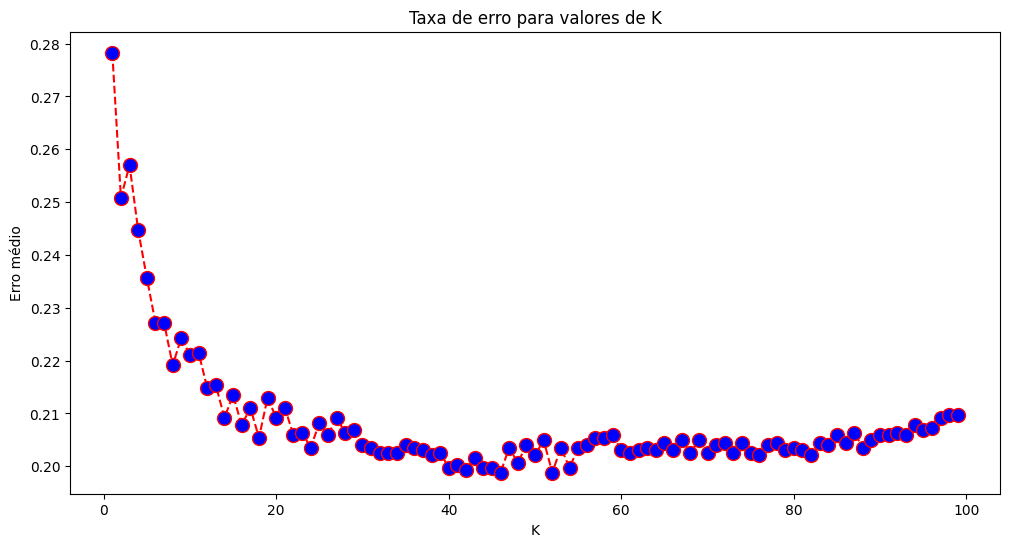

k = 46


In [10]:
import numpy as np

error = []

for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taxa de erro para valores de K')
plt.xlabel('K')
plt.ylabel('Erro médio')
plt.show()

print(f'k = {error.index(min(error)) + 1}')

Abaixo, o treinamento do algoritmo ``KNeighborsClassifier`` com o número ideal de K encontrado.

In [11]:
knn = KNeighborsClassifier(n_neighbors=error.index(min(error)) + 1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8455    0.8942    0.8692      1560
           1     0.6436    0.5389    0.5866       553

    accuracy                         0.8012      2113
   macro avg     0.7445    0.7166    0.7279      2113
weighted avg     0.7926    0.8012    0.7952      2113



Claramente há uma melhora significativa no modelo otimizado, porém (lembrando que este notebook é uma apresentação simplificada, que vários testes foram realizados) o algoritmo KNN apresentou altíssima sensibilidade com os dados de teste. A cada seleção aleatória dos dados de teste, o valor de ``k`` sofre grande alteração. Mesmo apresentando valores significatisvos de ``Recall`` e ``F1-Score``, devido a sensibilidade aos dados de treinamento esse modelo foi considera ineficiente para o problema.

---

- #### **GridResearchCV**

Em todos os modelos a seguir, foi utilizado o algorítmo ``GridSearchCV``. Para simplificação da apresentação, não foi adicionado à este notebook.

O ``GridSearchCV`` é uma ferramenta poderosa do Scikit-Learn usada para otimizar hiperparâmetros de modelos de aprendizado de máquina. A escolha dos hiperparâmetros corretos é crucial para garantir que um modelo tenha o melhor desempenho possível em um conjunto de dados específico.

O principal objetivo do ``GridSearchCV`` é encontrar a combinação ideal de hiperparâmetros que maximiza o desempenho de um modelo dentro de um espaço de busca definido.

- **Hiperparâmetros**: São parâmetros configuráveis do modelo que não são aprendidos diretamente dos dados. Exemplos incluem a profundidade máxima de uma árvore de decisão, a taxa de aprendizado em um algoritmo de boosting, ou o C no SVM.
- **Validação Cruzada (Cross-Validation)**: É uma técnica para avaliar o quão bem um modelo se generalizará para um conjunto de dados independente, dividindo o conjunto de dados em partes de treinamento e teste múltiplas vezes.

##### Como Funciona o GridSearchCV?

- **Definir o Espaço de Busca:**
Especifique uma grade (grid) de hiperparâmetros que deseja testar. Isso é feito através de um dicionário onde as chaves são os nomes dos hiperparâmetros e os valores são as listas de configurações desses hiperparâmetros a serem testadas.

- **Execução das Combinações:**
O GridSearchCV treina e avalia o modelo para todas as combinações possíveis de parâmetros presentes na grade. Cada combinação é avaliada utilizando validação cruzada.

- **Validação Cruzada:**
Para cada conjunto de hiperparâmetros, uma validação cruzada é realizada, dividindo o conjunto de dados em "k" partes (ou folds). Para cada combinação, o modelo é treinado em "k-1" partes e validado na parte restante. Esse processo se repete "k" vezes.

- **Métrica de Avaliação:**
Durante a validação cruzada, o desempenho do modelo é avaliado com base em uma métrica específica, como acurácia, F1-score, recall, etc.

- **Seleção da Melhor Combinação:**
A combinação de hiperparâmetros que obtém a melhor média na métrica de avaliação durante a validação cruzada é selecionada como a "melhor".

- **Treinamento Final:**
Finalmente, o modelo é treinado com os melhores hiperparâmetros encontrados usando todo o conjunto de dados de treinamento.

---

## Modelo Random Forest

O Random Forest é um modelo de aprendizado de máquina poderoso e versátil, composto por múltiplas árvores de decisão que trabalham em conjunto para melhorar a precisão e a estabilidade das previsões. O Random Forest é um tipo de modelo de ensemble que utiliza várias árvores de decisão para criar previsões mais robustas. A ideia é que, ao combinar as previsões de diversas árvores, os erros individuais de cada uma são compensados, melhorando a acurácia geral.

Cada árvore de decisão é treinada em uma amostra aleatória com reposição (bootstrap) dos dados de treinamento. Isso gera diversidade entre as árvores, o que ajuda na redução do overfitting.
Seleção Aleatória de Atributos:

Em cada nó de uma árvore, uma seleção aleatória de um subconjunto dos atributos é usada para dividir os dados. Isso introduz ainda mais variabilidade, levando a uma maior resistência ao overfitting.
Output por Votação:

Para classificação, o Random Forest reúne previsões de todas as árvores e escolhe a classe por votação majoritária.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt', n_estimators=200, random_state=None)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8329    0.9013    0.8658      1560
           1     0.6376    0.4901    0.5542       553

    accuracy                         0.7937      2113
   macro avg     0.7353    0.6957    0.7100      2113
weighted avg     0.7818    0.7937    0.7842      2113



## Modelo Support Vector Machines

Support Vector Machines (SVM) é um poderoso algoritmo de aprendizado de máquina usado para tarefas de classificação e regressão. É particularmente conhecido por sua capacidade de encontrar um hiperplano de separação ótimo entre classes, mesmo em espaços de alta dimensionalidade.

O objetivo principal do SVM é encontrar o hiperplano que melhor separa as classes em um espaço de dados. Em duas dimensões, este hiperplano é uma linha; em dimensões superiores, é um plano ou hiperplano.

SVM encontra o hiperplano que maximiza a margem, que é a distância entre o hiperplano e os pontos de dados mais próximos de qualquer classe. Esses pontos são chamados de vetores de suporte. A maximização da margem ajuda a garantir que novos dados sejam classificados com maior confiança.

São os pontos de dados mais próximos do hiperplano. Eles definem a posição e orientação do hiperplano. Apenas esses pontos são usados no processo de otimização.

SVMs podem ser ajustados para funcionar em problemas não linearmente separáveis por meio do uso de kernels. Funções kernel transformam os dados em um espaço dimensional mais alto onde é possível encontrar um hiperplano de separação linear. Exemplos incluem o kernel linear, polinomial, radial basis function (RBF), e sigmoid.

In [13]:
from sklearn.svm import SVC

svc = SVC(C=100, gamma=0.001, kernel='rbf')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8244    0.9237    0.8712      1560
           1     0.6740    0.4448    0.5359       553

    accuracy                         0.7984      2113
   macro avg     0.7492    0.6843    0.7036      2113
weighted avg     0.7850    0.7984    0.7835      2113



## Modelo Neural Network

As Redes Neurais (ou Neural Networks) são modelos inspirados no funcionamento do cérebro humano, capazes de capturar relações complexas em dados de alta dimensionalidade. Elas são amplamente utilizadas em uma variedade de aplicações, desde tarefas de classificação até problemas de regressão, visão computacional e mais.

Os principais componentes de uma rede neural são os neurônios, organizados em camadas. Cada neurônio recebe entradas, aplica uma função de ativação a uma combinação linear dessas entradas, e passa a saída para a próxima camada.

- **Camada de Entrada**: Recebe dados de entrada diretamente.
- **Camadas Ocultas**: Onde acontece a maior parte do processamento. Cada camada oculta no modelo permite a rede aprender padrões complexos.
- **Camada de Saída**: Dá a previsão final, com base nas ativações da última camada oculta.

O algoritmo possue funções de ativação, que introduzem não-linearidade na rede, permitindo que modelos consigam aprender padrões complexos. Exemplos incluem ReLU (Rectified Linear Unit), Sigmoid, e Tanh.

- **Backpropagation**: Processo iterativo usado durante o treinamento para ajustar os pesos, minimizando o erro da previsão com base no cálculo do gradiente.
- **Função de perda**: Mede a diferença entre a previsão do modelo e o valor verdadeiro. Erros são propagados de volta através da rede para ajustar os pesos.
- **Algoritmos de Otimização**: Como o Stochastic Gradient Descent (SGD), Adam, e RMSprop são usados para atualizar os pesos com base nos gradientes calculados.

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', solver='sgd')
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8465    0.8942    0.8697      1560
           1     0.6452    0.5425    0.5894       553

    accuracy                         0.8022      2113
   macro avg     0.7458    0.7184    0.7295      2113
weighted avg     0.7938    0.8022    0.7963      2113



c:\Users\FabianoAmaral\source\repos\churn_model_ml\ml_churn\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Modelo XGBoost

O XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina poderoso, amplamente utilizado para a resolução de problemas de previsão, tanto em competições de ciência de dados quanto em aplicações práticas. Ele é famoso por sua eficiência, precisão e capacidade de ser otimizado para um desempenho superior. 
O XGBoost é uma implementação eficiente e escalável do framework Gradient Boosting. O gradient boosting cria um modelo robusto ao treinar uma sequência de modelos (geralmente árvores de decisão) onde cada novo modelo tenta corrigir os erros do modelo anterior.

Cada árvore subsequente é ajustada para prever os resíduos das previsões do conjunto anterior, e não os alvos diretamente. Isso se baseia na ideia de que se podemos prever bem o erro residual, podemos melhorar o modelo geral.

XGBoost minimiza uma função objetivo composta por uma função de perda que mede a diferença entre as previsões e os valores reais, e uma parte de regularização que penaliza a complexidade do modelo para evitar overfitting.

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8, gamma=0, colsample_bylevel=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print('-'*60)
print(classification_report(y_test, y_pred, digits=4))

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8288    0.9218    0.8728      1560
           1     0.6772    0.4629    0.5499       553

    accuracy                         0.8017      2113
   macro avg     0.7530    0.6924    0.7114      2113
weighted avg     0.7892    0.8017    0.7883      2113



- #### **Melhor Modelo**

Considerando o cenário de interesse na detecção da classe minoritária (Churn = 1), o modelo de ``Neural Networks`` é a melhor escolha com base no F1-Score mais alto. Isso sugere que ele equilibra melhor precisão e recall para a classe de churn, sendo preferível especialmente em problemas desbalanceados, onde identificar corretamente a classe minoritária é crucial.

Se o objetivo específico é maximizar a capacidade de identificar churners (aumentar o recall), as redes neurais também são preferenciais, dado seu alto recall. Portanto, para um balanceamento geral entre detectar churn e minimizar falsos positivos, ``Neural Networks`` demonstra ser a melhor escolha.

- #### **Probabilidade de Churn**

Finalmente, a melhor maneira de usar esse modelo é atribuir probabilidade de evasão para cada cliente, criar segmentos e criar estratégias sobre isso.

In [16]:
mlp = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', solver='sgd')
mlp = mlp.fit(X_remaining, y_remaining)

In [17]:
df['Probability'] = (mlp.predict_proba(df[X_train.columns])[:, 1] * 100).round(2)

df[['customerID', 'Churn', 'Probability']].head()

,customerID,Churn,Probability
0,7590-VHVEG,0,58.48
1,5575-GNVDE,0,3.85
2,3668-QPYBK,1,25.41
3,7795-CFOCW,0,3.68
4,9237-HQITU,1,72.05


---